### Detect and Map Fractures in a Medium
### Using the Amplitudes of Reflected Acoustic Waves

In this case we'll look at layers of rock and try to determine   
if the data shows potential for fractures.  
The motivation comes from geologic containment suitability studies for the purpose of CO2 Sequestration.  


In [140]:
# Imports
%matplotlib inline
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from IPython import display
import time
import math
from scipy.interpolate import griddata



In [141]:
#Load in data sets

#outline_points = np.loadtxt(r'C:\PyLearn\frac_data\survey_corners', dtype='int')
#trc_data = np.loadtxt(r'C:\PyLearn\frac_data\trc_data_py.txt', dtype='int')
#amp_data = np.loadtxt(r'C:\PyLearn\frac_data\amp_data_cap_py')

outline_points = np.loadtxt(r'C:\Users\Duxvader\dux_python\data\survey_corners', dtype='int')
trc_data = np.loadtxt(r'C:\Users\Duxvader\dux_python\data\trc_data_py', dtype='int')
amp_data = np.loadtxt(r'C:\Users\Duxvader\dux_python\data\amp_data_cap_py')


First gather the input data, the location and amplitudes of acoustic reflections from layers in the sub-surface.

In [142]:
print("trace data loaded:")
print(trc_data[:,0:-2])
print("size of trc data:", trc_data.shape)
print("sample amp data:", amp_data)

print("first cmp:", np.min(trc_data[:,0]), "last cmp:", np.max(trc_data[:,0]))


trace data loaded:
[[105786     80     46 ...,    114      1      1]
 [105788     80    226 ...,    116      1      2]
 [105790    239    226 ...,    118      1      3]
 ..., 
 [ 68607    159    226 ...,    231    882    984]
 [ 68609    319    226 ...,    233    882    985]
 [ 68611    479    226 ...,    235    882    986]]
size of trc data: (194854, 9)
sample amp data: [ 0.        0.        0.014728 ...,  0.        0.        0.021135]
first cmp: 68490 last cmp: 105824


TRC Geometry File order: CMP# | OFFSET | AZIMUTH | I-Line# | X-Line# | SIN# | SRF# | CDPX_COORD | CDPY_COORD

The technique relies on 3 primary inputs. The amplitude of reflected acoustic waves, the distance of the recording instrument from the source and the azimuth or direction of the recorder to the source.

Now we'll assess the distribution of offset and azimuth available.  Note the longer offset data (>2500m) is centered on 48° and 228°, 180° appart.

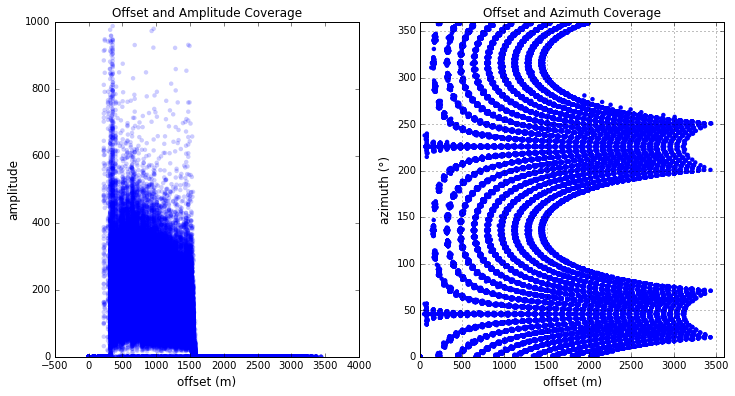

In [143]:
fig1, ax = plt.subplots(1,2,figsize=(12,6))
ax[1].scatter(trc_data[:,1],trc_data[:,2], edgecolor='none')
ax[1].set_xlabel('offset (m)', size=12)
ax[1].set_ylabel('azimuth (°)', size=12)
ax[1].set_xlim(0,3600)
ax[1].set_ylim(0,360)
ax[1].set_title('Offset and Azimuth Coverage', size=12)
ax[1].grid()

ax[0].scatter(trc_data[:,1],amp_data*10000, edgecolor='none', alpha=0.2)
ax[0].set_ylim(0,1000)
ax[0].set_xlabel('offset (m)', size=12)
ax[0].set_ylabel('amplitude', size=12)
ax[0].set_title('Offset and Amplitude Coverage', size=12)
plt.show()


Valid amplitude data appears to be limited to the 400m - 1500m offset range.  
Concentration of high amplitudes at near offset values.  
Amplitude values over 600 likely erroneous.  

Task List
1. Preliminary data inspection, remove outliers
2. Determine data limits and set analysis parameters
3. Loop through each bin, pull in amplitudes at their corresponding offset and azimuth, these will form a surface.  We'll look to perform a linear regression fit of amplitudes for given offset and azimuth according to a fractured medium model.
4. Calculate surface fit, store the solution, uncertainty and parameters for each grid bin
5. Plot solution at each bin location to form a map and address fracture potential.


In [164]:
# Task 1.1 - data prep, combine trc_data and amp_data, add an aditional column and merge arrays.
n = len(trc_data); p = trc_data.shape[1] # get the length 'n' and number of columns 'p'
temp_mat = np.zeros((n,p+1)) # add an additional column to zeros matrix
temp_mat[:,9] = amp_data*10000 # add in amplitudes x10000, preserve precision when converted to int later
temp_mat[:,0:9] = trc_data # add in trc_data
temp_mat = temp_mat.astype(int) 

print("Initial trc set length:", len(temp_mat))
amp_fit = temp_mat[:,-1]
amp_mean = np.mean(amp_fit)
amp_std = np.std(amp_fit)

temp_mat = temp_mat[(temp_mat[:,-1]>20) & (temp_mat[:,-1]<400)]
temp_mat = temp_mat[np.logical_and(temp_mat[:,1]>520, temp_mat[:,1]<1600)]

# use a subset of availble data for example purposes.
temp_mat = temp_mat[np.logical_and(temp_mat[:,4]>110, temp_mat[:,4]<190)]

print("Amplitude filter trc set length:", len(temp_mat))

trc_sort = temp_mat[temp_mat[:,0].argsort()] #sort by cdp#

for i in range(trc_sort.shape[0]):
    if trc_sort[i,2]>180: 
        trc_sort[i,2]=trc_sort[i,2]-180
        
rand_shift = np.random.rand(1)*200
trc_sort[:,3]=trc_sort[:,3]+rand_shift
trc_sort[:,4]=trc_sort[:,4]+rand_shift

print("first cmp:", np.min(trc_sort[:,0]), "last cmp:", np.max(trc_sort[:,0]))

Initial trc set length: 194854
Amplitude filter trc set length: 91987
first cmp: 68490 last cmp: 105816


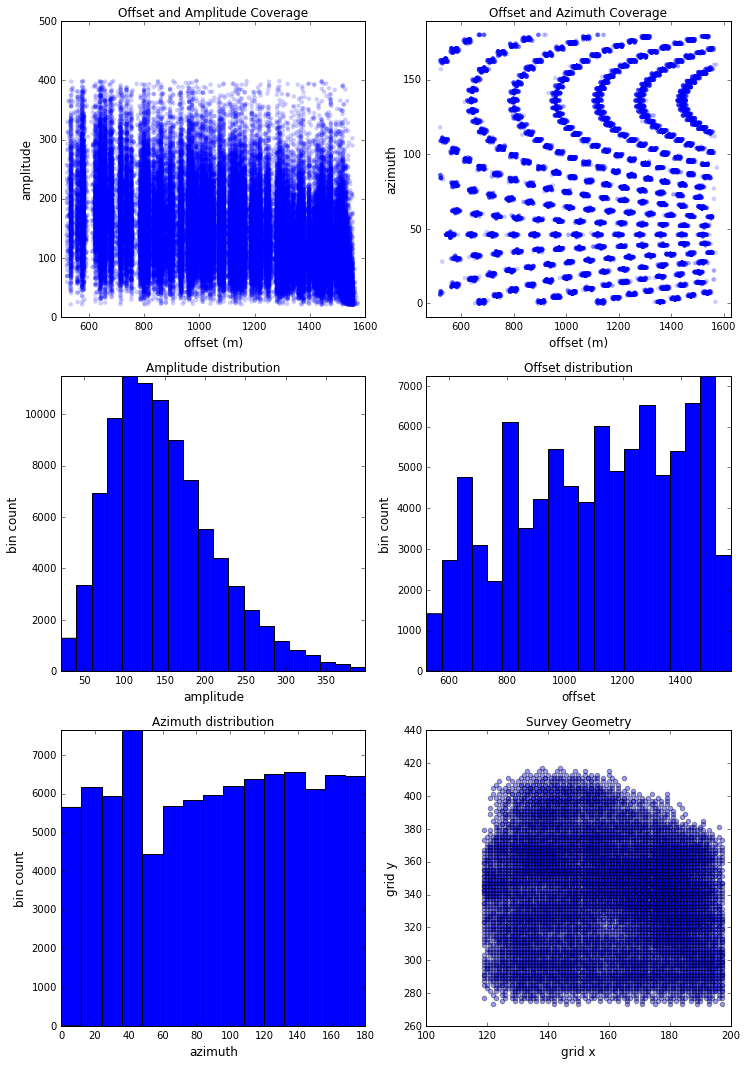

In [165]:
fig = plt.figure(figsize=(12,18))
# Fig top left
ax = fig.add_subplot(3,2,1)
amp_scat = plt.scatter(trc_sort[:,1],trc_sort[:,-1], edgecolor='none', alpha=0.2)
ax.set_ylim(0,500)
ax.set_xlim(500,1600)
ax.set_xlabel('offset (m)', size=12)
ax.set_ylabel('amplitude', size=12)
ax.set_title('Offset and Amplitude Coverage', size=12)

# Fig top right
ax = fig.add_subplot(3,2,2)
amp_scat = plt.scatter(trc_sort[:,1],trc_sort[:,2], edgecolor='none', alpha=0.2)
ax.set_ylim(0,180)
ax.set_xlabel('offset (m)', size=12)
ax.set_ylabel('azimuth', size=12)
ax.set_title('Offset and Azimuth Coverage', size=12)
ax.axis('tight')

# mid left
ax = fig.add_subplot(3,2,3)
amp_hist = plt.hist(trc_sort[:,-1], bins=20)
ax.set_xlabel('amplitude', size=12)
ax.set_ylabel('bin count', size=12)
ax.set_title('Amplitude distribution', size=12)
ax.axis('tight')

# mid right
ax = fig.add_subplot(3,2,4)
amp_hist = plt.hist(trc_sort[:,1], bins=20)
ax.set_xlabel('offset', size=12)
ax.set_ylabel('bin count', size=12)
ax.set_title('Offset distribution', size=12)
ax.axis('tight')

# lower left
ax = fig.add_subplot(3,2,5)
amp_hist = plt.hist(trc_sort[:,2], bins=15)
ax.set_xlabel('azimuth', size=12)
ax.set_ylabel('bin count', size=12)
ax.set_title('Azimuth distribution', size=12)
ax.axis('tight')

# lower right
ax = fig.add_subplot(3,2,6)
point_scatter = plt.scatter(trc_sort[::10,4], trc_sort[::10,3], alpha=0.4)
ax.set_xlabel('grid x', size=12)
ax.set_xlim(100,200)
ax.set_ylabel('grid y', size=12)
ax.set_title('Survey Geometry', size=12)
plt.show()


#### Data first look

Amplitudes appear slightly decreasing with offset.  
Amplitude - Azimuth space is reasonably well sampled in the 500-1600m offset range  
Amplitudes form a distrubiton centered around 120  
Offset sampling is reduced in the near (<1000m) offset range  
Azimuth is well sampled in the 0-180° range.  

Observing that the data are sufficient in amplitude, offset and azimuth distribution, we'll look to perform a least squares regression to determine if the data fit a fractured medium model

In [166]:
# Set step size and grouping dimensions
cdp_step = 1 #calculate solution at each grid location
cdp_bs = 1 #Primary bin ± 2*cdp_bs, which will be a 5x5 super bin size

#Approximate earth parameters
vint = 5130 # interval velocity of target horizon.
vrms = 2700 #rms velocity at target horizon
to = 1.100 #zero offset time in seconds

Inputs for the fractured medium calculation consist of a spatial components (x,y) in meters, sampling azimuth in degrees and a measure of reflected energy or amplitude.  

#### Bin data and perform least squares regression

In [167]:
%%time
# Task 2 - The meat.  Loop and get it done.

# Set starting values based on inputs
i_line = np.min(trc_sort[:,3]) #first iline position
x_line = np.max(trc_sort[:,4]) #first xline position
i_line_max = np.max(trc_sort[:,3]) #last iline
x_line_max = np.max(trc_sort[:,4]) #last xline
cdp_n = np.min(trc_sort[:,0]) # first cmp position in data
first_cdp = np.min(trc_sort[:,0])
position = 0
last_cdp = np.max(trc_sort[:,0]) #last cmp position in data

cdp_sample_select = 20000
sample_taken=False

# get unique cmp numbers and their indices
unique_cmp, cmp_indices = np.unique(trc_sort[:,0], return_index=True)
len_cmp = len(unique_cmp)

print("Start: 0")
print("End:",len_cmp)

# create an empty array to store the output for each cmp location, size is number of cmp locations in data
out_soln = np.empty([last_cdp-first_cdp,trc_sort.shape[1]])

# loop through a subset or all of the cmp locations
for n_cdp in range(0,len_cmp,cdp_step):
    
    # Get the current inline and xline values, (x,y) coordinates
    current_cdp = trc_sort[trc_sort[:,0]==unique_cmp[n_cdp]] # returns an array of all traces matching current cdp number
    il = current_cdp[0,3]; xl = current_cdp[0,4] # select the location properties from the first trace 
    cmp_x = current_cdp[0,7]; cmp_y = current_cdp[0,8] # select the location properties from the first trace 
    cmp_number = current_cdp[0,0]
    
    # For a cmp location, select surrounding cmps according to the super bin size
    cdp_trc = trc_sort[(trc_sort[:,3] >= (il-2*cdp_bs)) & (trc_sort[:,3] <= (il+2*cdp_bs)) 
                       & (trc_sort[:,4] >= (xl-2*cdp_bs)) & (trc_sort[:,4] <= (xl+2*cdp_bs)) ]  
    # Surface Fitting
    # Step 1. Data prep.
    # amplitude
    amp_fit = cdp_trc[:,-1].reshape(len(cdp_trc),1)

    # offset in terms of sin(theta)^2
    off_fit = cdp_trc[:,1]/2 # take 1/2 the src-rec offset
    off_fit = ((vint/vrms)*(off_fit/(np.sqrt(off_fit**2+(to**2*vrms**2)))))**2 # offset in terms of sin(theta)^2, theta = incidence angle
    off_tansqr = np.tan(np.arcsin(np.sqrt(off_fit)))**2 # offset in terms of tan(theta)^2, theta = incidence angle
    
    # azimuth
    azm_fit = cdp_trc[:,2]
    
    # Determine Regression Coefficients
    pi = math.pi/180
    avoa_fit = np.array([np.ones(len(amp_fit)), (np.cos(azm_fit*pi)**2)*off_fit,
                np.cos(azm_fit*pi)*np.sin(azm_fit*pi)*off_fit*2,
                (np.sin(azm_fit*pi)**2)*off_fit, off_fit*off_tansqr]) # 4th term  off_fit*off_tansqr - removed
    avoa_fit=avoa_fit.T
    avoa_coefs,resid,rank,s = np.linalg.lstsq(avoa_fit,amp_fit) # least squares regression.
    
    # Calculate the errors on the surface fit, observed amplitudes comapred to modeled amplitudes
    
    n = np.max(amp_fit.shape) # number of samples
    amp_model = np.dot(avoa_fit,avoa_coefs)
    residuals = amp_fit - amp_model #observed amplitudes - model surface fit amplitude
    RSS = sum(residuals**2) # sum of squared residuals
    TSS = sum((amp_fit-np.mean(amp_fit))**2) # total sum of squares
    R2 = 1 - RSS/TSS # r squared
    std_error = np.sqrt(RSS/(n-len(avoa_coefs)))
    std_y = np.sqrt(TSS/(n-1))
    R2_adj = 1 - (std_error/std_y)**2  # adjusted R squared
    
    # Calculate the modeled azimuth from the regression fit
    frac_az = np.arctan(((avoa_coefs[1]-avoa_coefs[3])+
                         np.sqrt((avoa_coefs[1]-avoa_coefs[3])**2+
                        (avoa_coefs[2]**2)*4))/(avoa_coefs[2]*2))
    frac_az = frac_az*(180/np.pi) # convert to degrees
    
    # flip all values to zero - 180 degrees
    if frac_az>180:
        frac_az = frac_az - 180
    if frac_az<0:
        frac_az = frac_az + 180
    
    # Calculate the modeled magnitude of anisotropy from the regression fit
    g_aniso = np.sqrt((avoa_coefs[1]-avoa_coefs[3])**2+(avoa_coefs[2]**2)*4)
    
    # Capture the output for plotting later
    out_soln[position,0]=current_cdp[0,0] # cmp number
    out_soln[position,1]=cmp_x # cmp_x coordinate
    out_soln[position,2]=cmp_y # cmp_y coordinate
    out_soln[position,3]=il # inline #
    out_soln[position,4]=xl # xline #
    
    # store the fracture gradient magnitude and orientation azimuth
    out_soln[position,5]=g_aniso
    out_soln[position,6]=frac_az
    
    # store the associated adjusted R squared value
    out_soln[position,7]=R2_adj
    
    # store the standard error
    out_soln[position,8]=std_error
    
    # store the ratio of standard error / mean amplitude
    out_soln[position,9]=std_error/np.mean(amp_model)
    
    if (cmp_number > cdp_sample_select and sample_taken==False and len(cdp_trc)>500):
        example_cdp = cdp_trc
        example_soln = out_soln[position,:]
        example_model = amp_model
        print('data points in example location:',len(cdp_trc))
        sample_taken=True      
      
    # Increment output position index
    position +=1
      
print("Crunched",position,"super cmp bins")    
    

Start: 0
End: 5284
data points in example location: 501
Crunched 5284 super cmp bins
Wall time: 26.9 s


A calculation of the azimuthal variation of acoustic wave reflection amplitude with offset and azimuth has been made at each grid location using least squares regression.

### Data Sorting

Samples for each grid (bin) location are gathered from the raw data set.  Adjacent grid locations are collected to form a super binned data set (CMP bin and Location).  Super binning provides more complete coverage of the offset - azimuth space in order to get a more robust fit of the raw data to the model (Geometry Distribution).

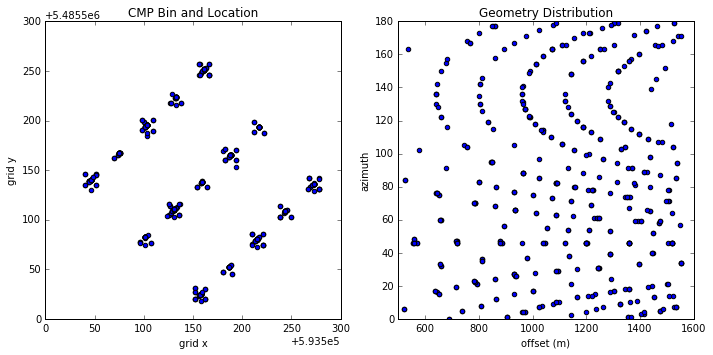

In [168]:
fig2,ax = plt.subplots(1,2, figsize=(10,5))
rand_shift = np.random.rand(1)*50000
ax[0].scatter(example_cdp[:,7]+rand_shift,example_cdp[:,8]+rand_shift)
#ax[0].plot(outline_points[:,0],outline_points[:,1])
ax[0].set_title('CMP Bin and Location')
ax[0].set_ylabel('grid y')
ax[0].set_xlabel('grid x')

ax[1].scatter(example_cdp[:,1],example_cdp[:,2])
ax[1].set_title('Geometry Distribution')
ax[1].set_xlim(500,1600)
ax[1].set_ylim(0,180)
ax[1].set_ylabel('azimuth')
ax[1].set_xlabel('offset (m)')

plt.tight_layout()
plt.show()

### Least Squares Regression

With amplitudes gathered at their corresponding offset and azimuth positions a least squares regression is performed to determine the amplitude variation with offset and azimuth.  In 2D space this can be observed below as the raw amplitudes (blue) are shown with the regression fit (red).  Generally reflection amplitudes will decrease with reflection incidence angle.  

Fractures may be expressed as anisotropy or a difference in property with measuring direction (azimuth).  Mild flexure of the red surface in the amplitude-azimuth space is an example of azimuthal anisotropy of reflection amplitudes.

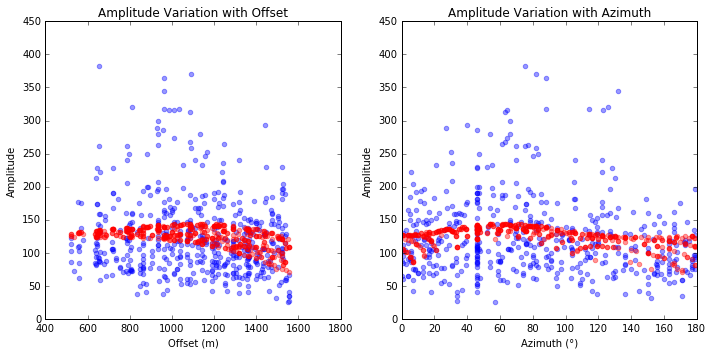

In [169]:
fig2,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(example_cdp[:,1],example_cdp[:,9], color='blue',alpha=0.4)
ax[0].scatter(example_cdp[:,1],example_model, color='red',alpha=0.4)
#ax[0].plot(outline_points[:,0],outline_points[:,1])
ax[0].set_title('Amplitude Variation with Offset')
ax[0].set_xlabel('Offset (m)')
ax[0].set_ylabel('Amplitude')

ax[1].scatter(example_cdp[:,2],example_cdp[:,9], color='blue',alpha=0.4)
ax[1].scatter(example_cdp[:,2],example_model, color='red',alpha=0.4)
ax[1].set_xlim(0,180)
ax[1].set_title('Amplitude Variation with Azimuth')
ax[1].set_xlabel('Azimuth (°)')
ax[1].set_ylabel('Amplitude')



plt.tight_layout()
plt.show()


### Surface Fit Visualized

In 3 dimensions the surface fit can be seen to be varying from higher amplitudes (warm color) to lower amplitudes (cool color).  The maximum and minimum deviation of amplitude with azimuth are the principle stress directions where natural fractures will be oriented along the maximum stress direction.

shape of x (501,)


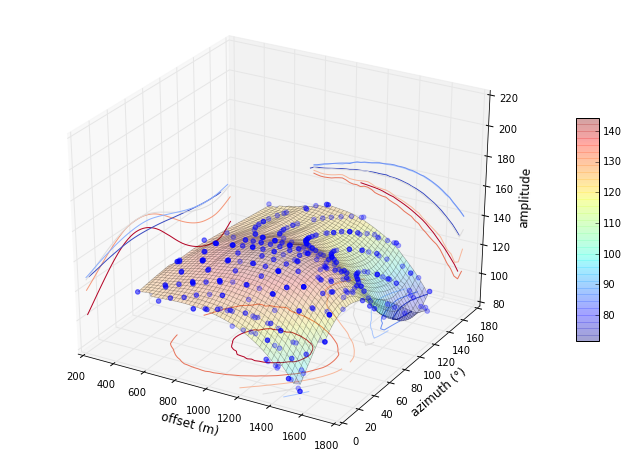

In [170]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection='3d')

x=np.reshape(example_cdp[:,1],len(example_cdp[:,1]))
print('shape of x',x.shape)
y = np.reshape(example_cdp[:,2],len(example_cdp[:,2]))
z = np.reshape(example_model,len(example_model))

xlin = np.linspace(400,1600,50)
ylin = np.linspace(0,180,60)
X,Y = np.meshgrid(xlin,ylin)
Z = griddata((x,y),z,(X,Y),method='cubic')

# find min/max of Z for color bar scaling since the gridded data will contain nans that 
# throw off the color scaling
zmin = Z[np.where(np.isnan(Z) == False)].min()
zmax = Z[np.where(np.isnan(Z) == False)].max()

cset = ax.contour(X, Y, Z, zdir='z', offset=80, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=200, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=220, cmap=cm.coolwarm)
surf = ax.plot_surface(X, Y, Z, rstride=1,cstride=1,cmap=cm.jet,
                       linewidth=0.5, antialiased=True, alpha=0.2, vmin=zmin, vmax=zmax, edgecolors='black')

ax.scatter(example_cdp[:,1],example_cdp[:,2], example_model, color='blue', alpha=0.3) 

fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_xlim(200,1800)
ax.set_ylim(0,180)
ax.set_zlim(80,220)
ax.set_xlabel('offset (m)', size=12)
ax.set_ylabel('azimuth (°)', size=12)
ax.set_zlabel('amplitude', size=12)


plt.show()

In [171]:
out_clean = out_soln[out_soln[:,0]!=0]
print("Unruly CMP gathers:",out_clean.shape[0])
out_clean = out_clean[~np.isnan(out_clean).any(axis=1)]
print("After removing NaNs",out_clean.shape[0])
out_clean = out_clean[out_clean[:,7]>0]
print("After negative correlations",out_clean.shape[0])
out_clean = out_clean[out_clean[:,5]<12000]
print("After erroneous gradients",out_clean.shape[0])


Unruly CMP gathers: 5284
After removing NaNs 5284
After negative correlations 5152
After erroneous gradients 5135


In [172]:
# Setup plotting data and grid parameters
# out_solution x,y,magnitude,azimuth (1,2,5,6)
# x=np.reshape(out_clean[:,1],len(out_clean[:,1]))
# y = np.reshape(out_clean[:,2],len(out_clean[:,2]))
# z = np.reshape(out_clean[:,5],len(out_clean[:,5]))

# xlin = np.linspace(np.min(x),np.max(x),int((np.max(x)-np.min(x))/100))
# ylin = np.linspace(np.min(y),np.max(y),int((np.max(y)-np.min(y))/100))

x = np.reshape(out_clean[:,4],len(out_clean[:,4]))
y = np.reshape(out_clean[:,3],len(out_clean[:,3]))
z = np.reshape(out_clean[:,5],len(out_clean[:,5]))

xlin = np.linspace(np.min(x),np.max(x),(np.max(x)-np.min(x))/1)
ylin = np.linspace(np.min(y),np.max(y),(np.max(y)-np.min(y))/1)

X,Y = np.meshgrid(xlin,ylin)
binsize=50
Z = griddata((x,y),z,(X,Y),method='cubic')

print('shape of grid Z',Z.shape)
zi, yi, xi = np.histogram2d(y, x, bins=Z.shape, weights=z, normed=False)
zi = np.ma.masked_equal(zi, 0)
unit_grid = zi/zi
Z_masked = np.ma.masked_where(0,Z)
Z_masked = np.ma.masked_where(np.isnan(Z),Z)

zmin = Z_masked[np.where(np.isnan(Z_masked) == False)].min()
zmax = Z_masked[np.where(np.isnan(Z_masked) == False)].max()

shape of grid Z (144, 78)


 ### Distribution of results for the survey area
 
 Below we'll look at the inversion results for each grid cell in the survey.  For each grid cell a determination of the intensity of anisotropy (azimuthal gradient) has been made which is related to the inferred fracture density.  The orientation of the anisotropy (inferred fractures) is also recorded as well as the errors in the least squares regression.

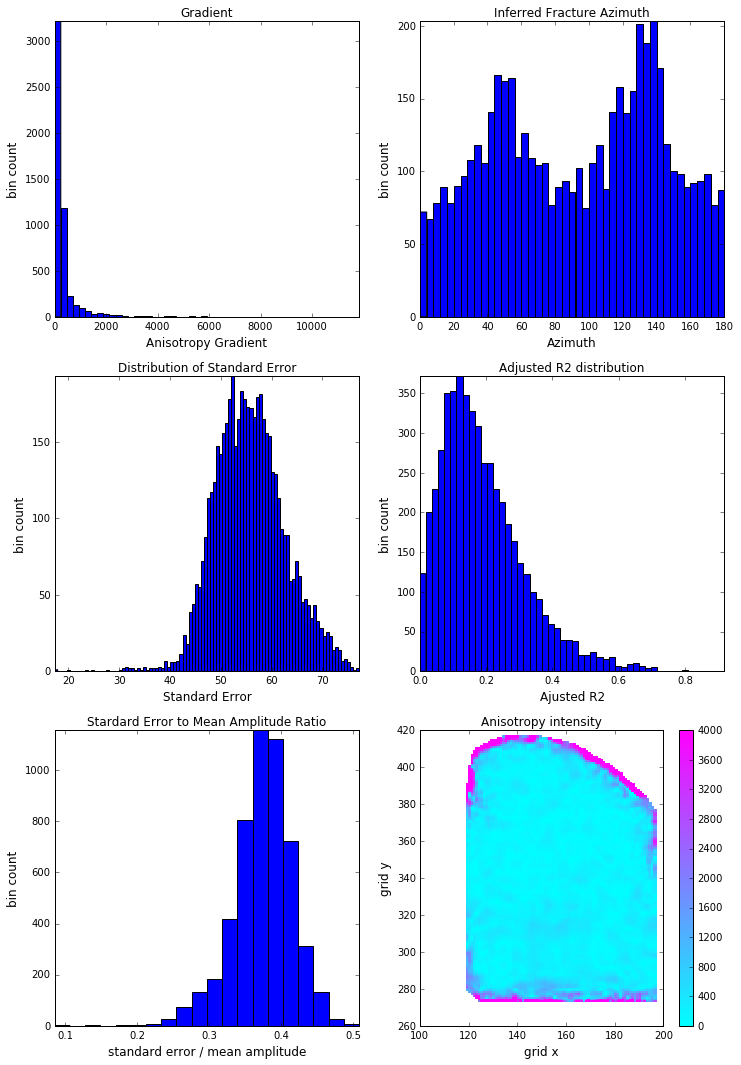

In [173]:
fig = plt.figure(figsize=(12,18))
# Fig top left
ax = fig.add_subplot(3,2,1)
amp_hist = plt.hist(out_clean[:,5], bins=50)
ax.set_xlabel('Anisotropy Gradient', size=12)
ax.set_ylabel('bin count', size=12)
ax.set_title('Gradient', size=12)
ax.axis('tight')

# Fig top right
ax = fig.add_subplot(3,2,2)
amp_hist = plt.hist(out_clean[:,6], bins=45)
ax.set_xlabel('Azimuth', size=12)
ax.set_ylabel('bin count', size=12)
ax.set_title('Inferred Fracture Azimuth', size=12)
ax.axis('tight')

# mid left
ax = fig.add_subplot(3,2,3)
amp_hist = plt.hist(out_clean[:,8], bins=100)
ax.set_xlabel('Standard Error', size=12)
ax.set_ylabel('bin count', size=12)
ax.set_title('Distribution of Standard Error', size=12)
ax.axis('tight')

# mid right
ax = fig.add_subplot(3,2,4)
amp_hist = plt.hist(out_clean[:,7], bins=50)
ax.set_xlabel('Ajusted R2', size=12)
ax.set_ylabel('bin count', size=12)
ax.set_title('Adjusted R2 distribution', size=12)
ax.axis('tight')


# lower left
ax = fig.add_subplot(3,2,5)
amp_hist = plt.hist(out_clean[:,9], bins=20)
ax.set_xlabel('standard error / mean amplitude', size=12)
ax.set_ylabel('bin count', size=12)
ax.set_title('Stardard Error to Mean Amplitude Ratio', size=12)
ax.axis('tight')

# lower right
ax = fig.add_subplot(3,2,6)

surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=0, vmax=4000,cmap='cool')
fig.colorbar(surf)
#point_scatter = plt.scatter(out_clean[::2,4], out_clean[::2,3], alpha=0.4)
#point_scatter_filter = plt.scatter(out_clean[out_clean[:,7]>0.5][:,4],out_clean[out_clean[:,7]>0.5][:,3], alpha=0.4, c='r')
ax.set_xlabel('grid x', size=12)
ax.set_xlim(100,200)
ax.set_ylabel('grid y', size=12)
ax.set_title('Anisotropy intensity', size=12)

plt.show()

### Inversion output: first look

Anisotropy gradient is mostly below 2000 with a few outliers pushing up to 12,000
Azimuth orientations are well sampled with concentrations around 50° and 140°
The standard error is reasonably distributed around 55
Adjusted Rsquared value is mostly below 0.4 capturing the scatter in the input data.
Preliminary maps of the anisotropy intensity reveal that the majority of the survey area is <2000

High intensity areas (>2000) are almost exclusively on the fringe of the survey - this due to the limited azimuthal coverage.  
Limited azimuths on the edges leave the surface fit poorly constrained allowing for wild swings in the fit which 
produce large gradients (variation in amplitudes with azimuth).


#### Visualizing the Output

Now we'll look to create spatial plots or maps of the output and assess the potential for fracture character in the data

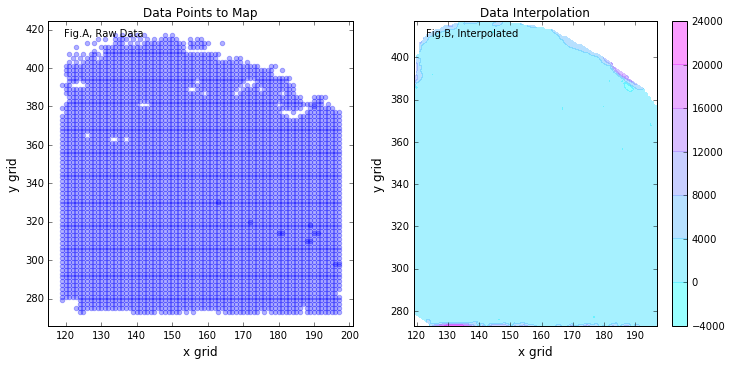

In [174]:
fig=plt.figure(figsize=(12,12))

#/// Upper left - Data Points and Grid
ax = fig.add_subplot(2,2,1)

ax.scatter(x[::1],y[::1], color='blue', alpha=0.3, s=20)
#fig.colorbar(grid_plot)
ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Data Points to Map')
ax.annotate('Fig.A, Raw Data',xy=(0.05,0.95),xycoords='axes fraction')
ax.axis('tight')
#///

#/// Upper Right - Grid and color
ax = fig.add_subplot(2,2,2)
surf = ax.contourf(X, Y, Z_masked, rstride=1,cstride=1,cmap='cool',
                      linewidth=0.4, antialiased=False, alpha=0.4,
                        vmin=zmin, vmax=zmax, edgecolors='black')
#ax.scatter(x[::1],y[::1], edgecolor='blue', facecolor='blue', alpha=0.3, s=10)
fig.colorbar(surf)

ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.annotate('Fig.B, Interpolated',xy=(0.05,0.95),xycoords='axes fraction')
ax.set_title('Data Interpolation')

ax.axis('tight')
#///

plt.show()

### Well, time to start digging.

#### Challenges
1. Data is being interpolated in blank areas where there are no measurements
2. The value range is being interpolated to extremes in areas of no data
3. Insights we might gain from local variability are being obscured by the color bar range 



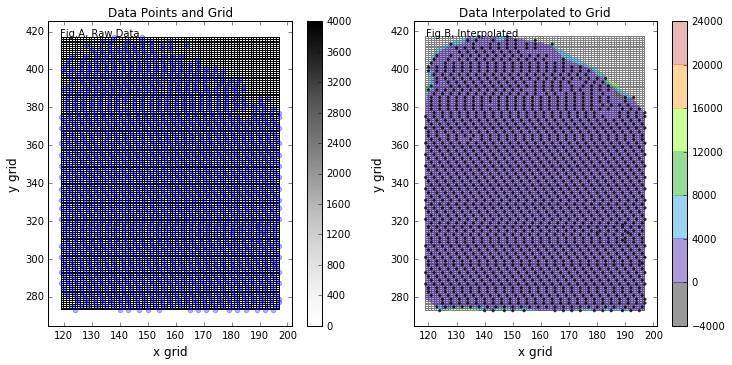

In [175]:
fig=plt.figure(figsize=(12,12))

#/// Upper left - Data Points and Grid
ax = fig.add_subplot(2,2,1)

grid_plot = ax.pcolormesh(xi, yi, np.zeros(Z_masked.shape), edgecolors='black',
                          linewidth=0.005,vmin=0, vmax=4000,cmap='Greys')
ax.scatter(x[::3],y[::3], color='blue', alpha=0.3, s=20)
fig.colorbar(grid_plot)
ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Data Points and Grid')
ax.annotate('Fig.A, Raw Data',xy=(0.05,0.95),xycoords='axes fraction')
ax.axis('tight')
#///

#/// Upper Right - Grid and color
ax = fig.add_subplot(2,2,2)
grid_plot = ax.pcolormesh(xi, yi, np.zeros(Z_masked.shape), edgecolors='grey',
                          linewidth=0.005,vmin=0, vmax=4000,cmap='Greys')
surf = ax.contourf(X, Y, Z, rstride=1,cstride=1,cmap='nipy_spectral',
                      linewidth=0.4, antialiased=True, alpha=0.4,
                        vmin=zmin, vmax=zmax, edgecolors='black')
ax.scatter(x[::3],y[::3], edgecolor='none', facecolor='black', alpha=0.8, s=10)
fig.colorbar(surf)

ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.annotate('Fig.B, Interpolated',xy=(0.05,0.95),xycoords='axes fraction')
ax.set_title('Data Interpolated to Grid')
ax.axis('tight')
#///

plt.show()

#### Displaying the grid it is easier to see what's happening here.  
The data is being interpolated between measurements.  
That can be fixed by masking to where we have observation points.  

Where we have observations the data range is consistently in the blue or 0-4,000 range.  
The color bar can be restricted to this range to bring out texture within the observation area.
Additionally, the plotting can be changed from binned colors to a more uniform display range

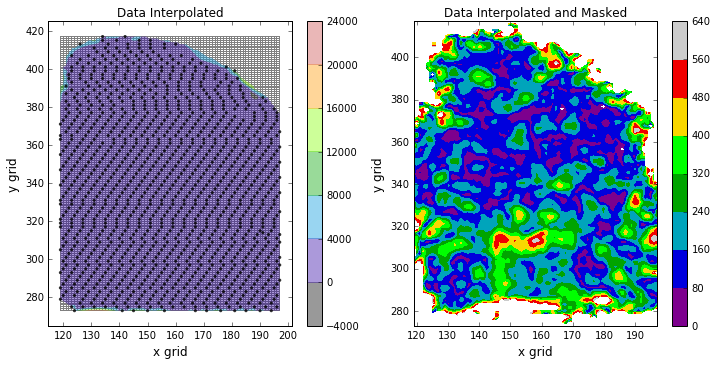

In [176]:
fig=plt.figure(figsize=(12,12))

#/// Upper Left - Grid and color
zmin = Z[np.where(np.isnan(Z) == False)].min()
zmax = Z[np.where(np.isnan(Z) == False)].max()
ax = fig.add_subplot(2,2,1)
grid_plot = ax.pcolormesh(xi, yi, np.zeros(Z_masked.shape), edgecolors='grey',
                          linewidth=0.005,vmin=0, vmax=4000,cmap='Greys')
surf = ax.contourf(X, Y, Z, rstride=1,cstride=1,cmap='nipy_spectral',
                      linewidth=0.4, antialiased=True, alpha=0.4,
                        vmin=zmin, vmax=zmax, edgecolors='black')
ax.scatter(x[::4],y[::4], edgecolor='none', facecolor='black', alpha=0.8, s=10)
fig.colorbar(surf)
ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Data Interpolated')
ax.axis('tight')
#///
Z_masked[(Z_masked>600)]=np.NaN
Z_masked[(Z_masked<=0)]=np.NaN
Z_masked = np.ma.masked_where(np.isnan(Z_masked), Z_masked)
zmin = Z_masked[np.where(np.isnan(Z_masked) == False)].min()
zmax = Z_masked[np.where(np.isnan(Z_masked) == False)].max()

#/// Upper Right - Grid and color
ax = fig.add_subplot(2,2,2)
surf = ax.contourf(X, Y, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='nipy_spectral')
fig.colorbar(surf)
ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Data Interpolated and Masked')
ax.axis('tight')
#///


plt.show()

Now things are starting to become more clear.  

The extreme values appear to be located on the fringes of the observation points.  
The core of the measured data points have subtle variation within the 0-3000 range.  

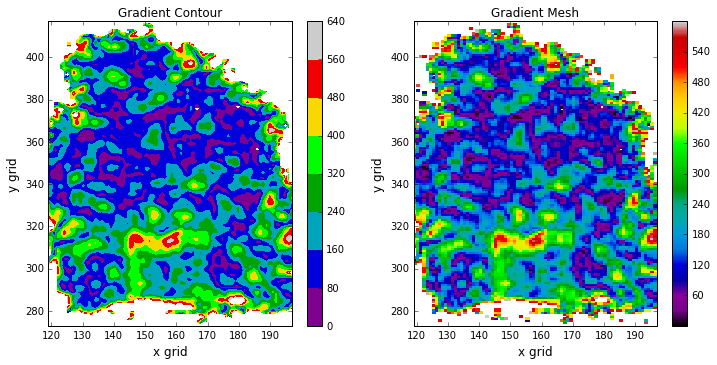

In [177]:
fig=plt.figure(figsize=(12,12))

#/// Upper Left - Grid and color
ax = fig.add_subplot(2,2,1)
surf = ax.contourf(X, Y, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='nipy_spectral')
fig.colorbar(surf)
ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Gradient Contour')
ax.axis('tight')
#///

#/// Upper right - Color Surf
ax = fig.add_subplot(2,2,2)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='nipy_spectral')
fig.colorbar(surf)
ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Gradient Mesh')
ax.axis('tight')
#///

plt.show()

### Getting there.

Now variations within the measured data can be observed.  
Most of the extreme values appear to be concentrated to the edges of observation area.  
This likely occurs because the sampling direction is limited at the boundaries of the survey.  

Next steps.
1. Select appropriate color scheme
2. Add in inferred fracture orientations

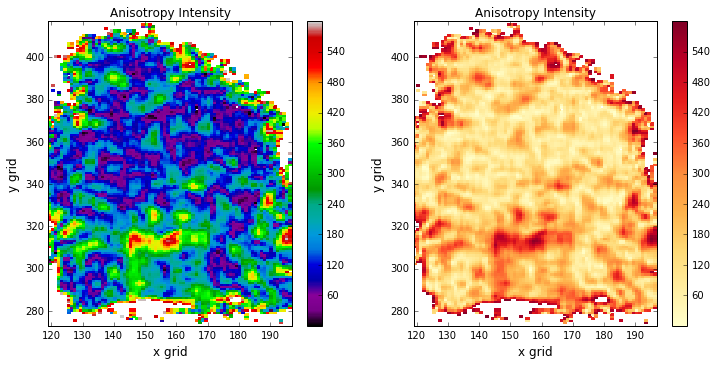

In [178]:
fig=plt.figure(figsize=(12,12))

#/// Upper Left - Color Surf
ax = fig.add_subplot(2,2,1)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='nipy_spectral')
fig.colorbar(surf)
ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Anisotropy Intensity')
ax.axis('tight')
#///

Z_masked[(Z_masked>600)]=np.NaN
Z_masked[(Z_masked<=0)]=np.NaN
Z_masked = np.ma.masked_where(np.isnan(Z_masked), Z_masked)

zmin = Z_masked[np.where(np.isnan(Z_masked) == False)].min()
zmax = Z_masked[np.where(np.isnan(Z_masked) == False)].max()

#/// Upper Left - Color Surf
ax = fig.add_subplot(2,2,2)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='YlOrRd')
fig.colorbar(surf)
ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Anisotropy Intensity')
ax.axis('tight')
#///

plt.show()

#### Now well plot the orientation of anisotropy which is the direction of inferred fractures.  The streamplot will help to visually separate the anisotropy orientations into domains of similar character.

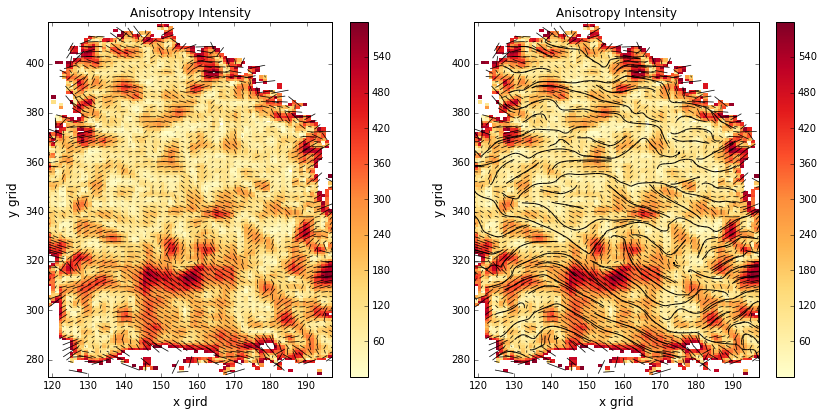

In [179]:
fig=plt.figure(figsize=(14,14))

ax = fig.add_subplot(2,2,1)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='YlOrRd')
fig.colorbar(surf)

# create sparse grid for quiver directional arrows
# to scale the quiver vectors from the Anisotropy Gradient we'll create a scaling grid QZ with 1/2 the cells
quiv_xlin = np.linspace(np.min(x),np.max(x),(np.max(x)-np.min(x))/2)
quiv_ylin = np.linspace(np.min(y),np.max(y),(np.max(y)-np.min(y))/2)

QX,QY = np.meshgrid(quiv_xlin,quiv_ylin)

# set up the quiver
z_az = out_clean[:,6] # azimuth orientation
Z_azm = griddata((x,y),z_az,(QX,QY),method='cubic')
QZ_masked = griddata((x,y),z,(QX,QY),method='cubic') #gradient scaling grid
QZ_masked = np.ma.masked_equal(QZ_masked, 0)

QZ_masked[(QZ_masked>600)]=np.NaN
QZ_masked[(QZ_masked<0)]=np.NaN
QZ_masked = np.ma.masked_equal(QZ_masked, 0)

UN = QZ_masked*0.01*np.sin(Z_azm*(np.pi/180))
VN = QZ_masked*0.01*np.cos(Z_azm*(np.pi/180))
plt.quiver(QX, QY, UN, VN, 
          color='k',angles='xy', scale_units='xy', scale=1, linewidth=0.05,headlength=1, headwidth=1, pivot='middle')
ax.set_xlabel('x gird', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Anisotropy Intensity')
ax.axis('tight')

#/// right plot
ax = fig.add_subplot(2,2,2)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                      linewidth=0.005,vmin=zmin, vmax=zmax,cmap='YlOrRd')
fig.colorbar(surf)

plt.quiver(QX, QY, UN, VN, 
           color='k',angles='xy', scale_units='xy', scale=1, linewidth=0.05,headlength=1, headwidth=1, pivot='middle')
plt.streamplot(QX, QY, UN, VN, linewidth=1,         # line thickness
               arrowstyle='-',     # arrow style
               arrowsize=1.5, color = 'black') 

ax.set_xlabel('x grid', size=12)
ax.set_ylabel('y grid', size=12)
ax.set_title('Anisotropy Intensity')

ax.axis('tight')
#///


plt.show()

### Fracture Maps

Here the orientation of anisotropy is plotted with an underlay of the intensity of anisotropy.  We can observe that the majority of the survey area is of low intensity and that data would not suggest the likely hood of natural fractures.  The higher intensity anisotropy areas in the southern portion of the survey show consistent orientation and spatial continuity.  These areas are of interest for natural fracture potential**.

** Natural fractures will produce anisotropy, however anisotropy can occur from natural and induced variations in the earth's stress field.  Mutliple fracture sets at different orientations will also act to diminish the intensity of anisotropy.  

code snipets for later:

Setting 3D plot view perspective:  
ax.view_init(-270,270)  
ax.axis('tight')  